# Imports

In [ ]:
#| default_exp training

In [ ]:
#|export
import pickle,gzip,math,os,shutil,torch,matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor, nn
import torch.nn.functional as F

In [ ]:
from fastcore.test import test_close
torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path = Path('data')
path_gz = path / 'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

x_train,y_train,x_valid,y_valid = map(torch.tensor,[x_train,y_train,x_valid,y_valid])

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist.pkl.gz'

# Initial setup

## Data

In [ ]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

Here is the simple nn implementation from the previous notebook. We will start building from it.

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross entropy loss

x here is a matrix of logits (outputs of the last layer of a nn). We convert logits to probabilities using softmax defined below.

$$ \hbox{softmax(x)}_{i} = \frac{e^{x}}{e^{x_{0}} +e^{x_{1}} + \cdots + e^{x_{n-1}} } $$

$$ \hbox{softmax(x)}_{i} = \frac{e^{x}}{\sum\limits_{0 \leq j \leq n}{e^{x_{j}}}} $$

Cross-entropy takes log of probabilities so we will define log_softmax function. # when working with a matix of (n,m) we can use `sum(1, keepdims=True)`. If we have extra dimension (batches) then we will nedd to sum across 2-nd dimension. To captue all of those cases we can just sum across the last dimension (-1).

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdims=True))).log()

In [ ]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

When working with logs, we can take advantage of the following relation:

$$ \log(\frac{a}{b}) = \log(a) - \log(b) $$

This will also add more stability and help avoid problems related to division (division by zero, exploding numbers, etc)

In [ ]:
def log_softmax(x): return x - (x.exp().sum(-1, keepdims=True)).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

This allows to avoid getting very large numbers during exponentiation.

In [ ]:
def logsumexp(x):
    m = x.max(dim=-1)[0]
    return m + ((x-m[:, None]).exp().sum(-1)).log()

In [ ]:
logsumexp(pred).shape

torch.Size([50000])

In [ ]:
test_close(logsumexp(pred), pred.logsumexp(-1))

We have recreated the built-in pytorch method `logsumexp` so we will use it going forward.

In [ ]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdims=True)

In [ ]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by: 
$$ -\sum x \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target. This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing) which is supported by PyTorch as well.

As a quick reminder, cross entrop loss simply finds the correct class and takes its log probability. If we have a perfect match the loss is zero $(log(1))$.

In [ ]:
y_train[:3]

tensor([5, 0, 4])

In [ ]:
sm_pred[:3]

tensor([[-2.37, -2.49, -2.36, -2.19, -2.32, -2.20, -2.32, -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44, -2.33, -2.30, -2.16, -2.34, -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28, -2.09, -2.36, -2.30, -2.38, -2.30, -2.30, -2.27]], grad_fn=<SliceBackward0>)

In [ ]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [ ]:
def nll(input, target): return -input[range(input.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Let's check our results against the PyTorch implementation

In [ ]:
test_close(loss, F.nll_loss(sm_pred, y_train))

PyTorch combines all of the above steps (`F.log_softmax` and `F.nll_loss`) into a single optimized function - `F.cross_entropy`.

In [ ]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

# Basic training loop

The basic training loop:
* get the output of the model on a batch of inputs
* compare the output to the true labels and compute the loss
* calculate the gradients of the loss with respect ot every parameter
* update said parameters with those gradients to make loss a bit better

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs = 50 # batch size
xb = x_train[:bs]
preds = model(xb)
preds.shape

torch.Size([50, 10])

In [ ]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [ ]:
loss_func(xb, yb)

tensor(6.84)

In [ ]:
preds.argmin(dim=1)

tensor([1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 6, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
#| export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.08)

In [ ]:
(preds.argmin(dim=1)==yb).float().mean()

tensor(0.14)

In [ ]:
lr = 0.5 # learning rate
epochs = 3 # epochs to train for

In [ ]:
#| export
def report(loss, preds, yb): print(f'{loss:.2f}, accuracy:{accuracy(preds,yb):.2f}')

In [ ]:
xb, yb = x_train[:bs], y_train[:bs]
pred = model(xb)
loss_func(pred, yb)
report(loss, preds, yb)

2.30, accuracy:0.08


In [ ]:
for epoch in range(epochs): # for each epoch
    for i in range(0, n, bs): # getting index for each next batch
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight += -lr * l.weight.grad
                    l.bias += -lr * l.bias.grad
                    l.weight.grad = None
                    l.bias.grad = None
    report(loss, preds, yb)

0.12, accuracy:0.98
0.12, accuracy:0.94
0.08, accuracy:0.96


In [ ]:
model.layers[0].weight

Parameter containing:
tensor([[ 0.02, -0.02, -0.01,  ...,  0.01, -0.00,  0.00],
        [-0.03, -0.02, -0.03,  ..., -0.00,  0.00, -0.02],
        [ 0.03, -0.01, -0.03,  ..., -0.01,  0.01, -0.03],
        ...,
        [-0.02, -0.01,  0.03,  ...,  0.02, -0.02,  0.02],
        [ 0.02,  0.03, -0.03,  ..., -0.00,  0.03, -0.02],
        [ 0.01,  0.00, -0.00,  ...,  0.03,  0.00,  0.03]], requires_grad=True)

In [ ]:
model.layers[0].weight

Parameter containing:
tensor([[ 0.02, -0.02, -0.01,  ...,  0.01, -0.00,  0.00],
        [-0.03, -0.02, -0.03,  ..., -0.00,  0.00, -0.02],
        [ 0.03, -0.01, -0.03,  ..., -0.01,  0.01, -0.03],
        ...,
        [-0.02, -0.01,  0.03,  ...,  0.02, -0.02,  0.02],
        [ 0.02,  0.03, -0.03,  ..., -0.00,  0.03, -0.02],
        [ 0.01,  0.00, -0.00,  ...,  0.03,  0.00,  0.03]], requires_grad=True)

# Using Parameters and optim

## Parameters 

This is not the intended usage of `nn.Module` but it can be done.

In [ ]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

We can check the children of `m1` and all of its `parameters`. The methods below return generators, so we wrap them intol lists to get back the stored values.

In [ ]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

We can recreate this functionailty ourselves. Note, that we don't need the special `__call__` method, because the implement the `forward` method that is called automatically by` __call__`.

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x): return   self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(m, nh, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


We can use `parameters` to update the weights without calling each layer separately

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            #import ipdb; ipdb.set_trace()
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): 
                    p += -lr * p.grad
                    p.grad = None
                
        report(loss, preds, yb)

In [ ]:
fit()

0.19, accuracy:0.96
0.11, accuracy:0.96
0.04, accuracy:1.00


PyTorch knows what parameters are by using `__setattr__`. The `__setattr__` method is called each time an attribute is set, just before the actual assignment occurs. This allows us automatically to include the relevant layers to the dict module.

In [ ]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()
            #for p in l.parameters(): yield p

In [ ]:
o = MyModule(m, nh, 10)
o

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
for p in o.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

This apporach will not work when we define layers all at once in the list:
`self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]`. We need to register each of them as modules.

In [ ]:
from functools import reduce

In [ ]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [ ]:
layers[0]

Linear(in_features=784, out_features=50, bias=True)

`Reduce` applies a function of two arguments cumulatively to the items of a sequence,
from left to right. If initial value is provided (x) it is placed before the items
of the sequence. This is is equivalent to
```
for l in self.layers: x = l(x)
        return x
```

In [ ]:
# implementation of factorial with reduce
reduce(lambda x,y: x*y, range(1,11), 1)

3628800

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self, x): return reduce(lambda x, l: l(x), self.layers, x)

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

Instead of manually calling `add_module` on the layers, we can use PyTorch class `nn.ModuleList`

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
   
    def forward(self, x):
        return reduce(lambda x,l: l(x), self.layers, x)

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

0.12, accuracy:0.96
0.11, accuracy:0.96
0.07, accuracy:0.98


### nn.Sequential

`nn.Sequential` does the same as above in one go

In [ ]:
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [ ]:
model = nn.Sequential(*layers)

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.05, accuracy:0.98
0.03, accuracy:1.00
0.02, accuracy:1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.optim

Now let's create our optimizer

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad = None

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())

Now we can rewrite our training loop as follows:

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, preds, yb)

0.16, accuracy:0.94
0.13, accuracy:0.96
0.08, accuracy:0.96


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, accuracy:0.94
0.13, accuracy:0.96
0.11, accuracy:0.94


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
xb = x_train[s]
    yb = y_train[s]
```
Instead, let's do these two steps together, by introducing a Dataset class:
```python
xb,yb = train_ds[s]
```

In [ ]:
#| export
class Dataset:
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return (self.x[i], self.y[i])

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [ ]:
xb, yb = train_ds[0:5]
assert xb.shape == (5,m)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(i+bs, n)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, accuracy:0.98
0.09, accuracy:0.98
0.07, accuracy:0.98


### Dataloader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```
Let's make our loop much cleaner, using a data loader:
```python
for xb,yb in train_dl:
    ...
```

Dataloader will allow us to iterate through the data without explicitly writing out the loop. This is aschieved by using `__iter__` method.

In [ ]:
class Dataloader:
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        for i in range(0, n, self.bs): yield self.ds[i:min(i+self.bs, n)]

In [ ]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

tensor(5)

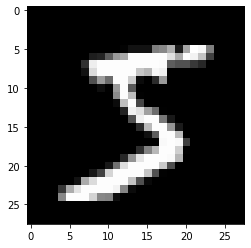

In [ ]:
plt.imshow(xb[0].view(28,28));
yb[0]

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, accuracy:0.96
0.11, accuracy:0.94
0.09, accuracy:0.96


Great! We singificantly simplified the training loop. Now let's build on top of this an firstly tackle random sampling.

### Random Sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [ ]:
import random

In [ ]:
class Sampler:
    def __init__(self, ds, shuffle=False): self.ds, self.shuffle = ds, shuffle
    def __iter__(self):
        res = list(range(len(self.ds)))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [ ]:
ss = Sampler(train_ds, shuffle=False)
it = iter(ss)

In [ ]:
next(it)

0

In [ ]:
for o in range(10): print(next(it))

1
2
3
4
5
6
7
8
9
10


Now we want to have a batched sampler than will produce `n` batches of `m` elements each

In [ ]:
# takes iterable and stop value
from itertools import islice
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [ ]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[15062, 36398, 40185, 30273, 17753]

In [ ]:
import fastcore.all as fc

In [ ]:
def simple_chunkate(it, bs):
    for _ in range(0, n, bs):
        yield list(islice(it, bs))

In [ ]:
class BatchSampler:
    def __init__(self, sampler, bs): fc.store_attr()
    def __iter__(self): yield from simple_chunkate(iter(self.sampler), self.bs)#fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[40763, 23688, 13667, 15060],
 [47449, 35528, 42501, 37471],
 [45159, 44332, 15840, 10497],
 [15046, 37007, 29332, 45454],
 [398, 37502, 6255, 2235]]

We can substitute `simple_chunkate` with a more sophisticated version from `fastcore` that is more flexible and takes care of some issues for us.

In [ ]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[5455, 34485, 45025, 16596],
 [15412, 49535, 46090, 39437],
 [2, 34958, 26203, 10019],
 [28379, 15745, 41260, 11864],
 [18538, 15395, 31063, 42105]]

Let's sum up to this point. 
* `Dataset` is a simple wrapper around xs and ys. It stores those values, has length and get be indexed into to return a tuple.
* `Dataloader` yields batches of a given size from a `Dataset`
* `Sampler` is a simple sampler that takes a `Dataset` and produces a single index (optionally random) from the dataset. This index can be used to index into a Dataset
* `BatchSampler` takes a sampler and a batch size. It yields a batch of indices of given size that can be used to index into a `Dataset`. `BatchSampler` returns when all batches have been yielded.

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs): fc.store_attr()
    def __iter__(self): yield (self.ds[next(iter(self.batchs))])

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

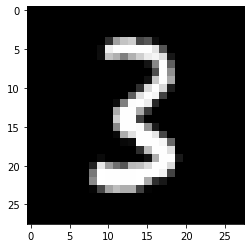

In [ ]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

Great, it works! Note, that this implementations differs from PyTorch approach, that uses a __collation function__ to decide how to aggregate data from a batch. We can replicate that approach below.

In [ ]:
d = next(iter(train_samp)) # on loop over self.batchs (train_samp)
p = [train_ds[i] for i in d][0] # self.ds[i] for i in b 

We get a tuple of tuples and need to collate that in a suitable way.

In [ ]:
# b is a tuple
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

In [ ]:
next(next(iter(valid_dl)))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4]))

tensor(3)

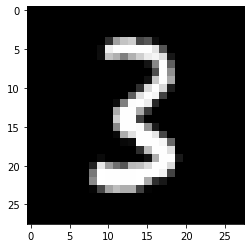

In [ ]:
xb, yb = next(next(iter(valid_dl)))
plt.imshow(xb[0].view(28, 28))
yb[0]

Notice that to get to the actual values we needed to call `next` twice. This is because the result of the yield is a generator. We can avoid this in two ways: either write and explicit loop or use 
```python
yield from
```

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        for v in (self.collate_fn(self.ds[i] for i in b) for b in self.batchs):
            yield v

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

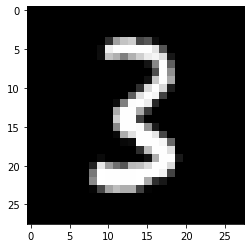

In [ ]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

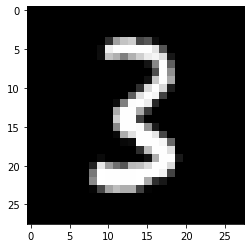

In [ ]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

### Multiprocessing DataLoader

In [ ]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [ ]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [ ]:
class Dataloader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [ ]:
train_dl = Dataloader(train_ds, batchs=train_samp, n_workers=1)
it = iter(train_dl)

In [ ]:
#xb,yb = next(it)
#xb.shape,yb.shape

## PyTorch DataLoader

Let's see how everythin we build above works using PyTorch classes and methods

In [ ]:
#|export 
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds),bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, accuracy:0.98
0.09, accuracy:0.98
0.06, accuracy:1.00


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In PyTorch we can skip creating `train_sampl` and `valid_samp` separately and create them inside the `DataLoader` using `sampler` keyword

In [ ]:
train_dl = DataLoader(train_ds,bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate RandomSampler / SequentialSampler automatically

In [ ]:
train_dl = DataLoader(train_ds,bs, shuffle=True, collate_fn=collate, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, collate_fn=collate)

In [ ]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, accuracy:0.94
0.10, accuracy:0.96
0.05, accuracy:1.00


(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

In [ ]:
len(next(iter(train_samp)))

50

Our dataset actually already knows how to sample a batch of indices all at once by indexing directly:

```pyton
train_ds[[4,6,7]]
```
That means that we can actually skip the batch_sampler and collate_fn entirely:

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should have a validation set in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0., 0.
            for xb, yb in valid_dl:
                preds = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(preds, yb).item() * n
                tot_acc += accuracy(preds, yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))

In [ ]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [ ]:
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1611832752637565 0.9530000042915344
1 0.11640510937198996 0.9665000069141388
2 0.10893300825729967 0.9684000074863434
3 0.11510496831964702 0.9662000024318695
4 0.10246456737630069 0.9707000076770782
CPU times: user 1min 25s, sys: 197 ms, total: 1min 26s
Wall time: 14.4 s


## Export - 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| hide
#from nbdev.export import nb_export
#nb_export('04_minibatch_training.ipynb', '.')